## Importing Packages

In [1]:
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fastf1.plotting.setup_mpl()

## Loading Session Data

In [2]:
year = 2019
race = "Abu Dhabi Grand Prix"

session = fastf1.get_session(year, race, 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (842.15 MB) C:\Users\odath\AppData\Local\Temp\fastf1


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No 

## Loading and Preparing Lap Data

In [3]:
laps = session.laps
laps = laps.sort_values(['Driver', 'LapNumber'])
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
275,0 days 00:35:20.821000,ALB,23,0 days 00:01:49.439000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:44.842000,...,Red Bull Racing,0 days 00:33:31.194000,2019-12-01 13:13:31.397,12,5.0,False,,False,False,109.439
276,0 days 00:37:05.332000,ALB,23,0 days 00:01:44.511000,2.0,1.0,NaT,NaT,0 days 00:00:18.175000,0 days 00:00:44.358000,...,Red Bull Racing,0 days 00:35:20.821000,2019-12-01 13:15:21.024,1,5.0,False,,False,True,104.511
277,0 days 00:38:49.158000,ALB,23,0 days 00:01:43.826000,3.0,1.0,NaT,NaT,0 days 00:00:18.079000,0 days 00:00:44.184000,...,Red Bull Racing,0 days 00:37:05.332000,2019-12-01 13:17:05.535,1,5.0,False,,False,True,103.826
278,0 days 00:40:33.039000,ALB,23,0 days 00:01:43.881000,4.0,1.0,NaT,NaT,0 days 00:00:18.041000,0 days 00:00:44.252000,...,Red Bull Racing,0 days 00:38:49.158000,2019-12-01 13:18:49.361,1,5.0,False,,False,True,103.881
279,0 days 00:42:17.149000,ALB,23,0 days 00:01:44.110000,5.0,1.0,NaT,NaT,0 days 00:00:18.089000,0 days 00:00:44.433000,...,Red Bull Racing,0 days 00:40:33.039000,2019-12-01 13:20:33.242,1,5.0,False,,False,True,104.110


## Compound color map

In [4]:
COMPOUND_COLORS = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFD700',
    'HARD': "#C6BFBF",
    'INTERMEDIATE': '#39B54A',
    'WET': '#0077FF'
}

## Race Statergy Comparison between different drivers

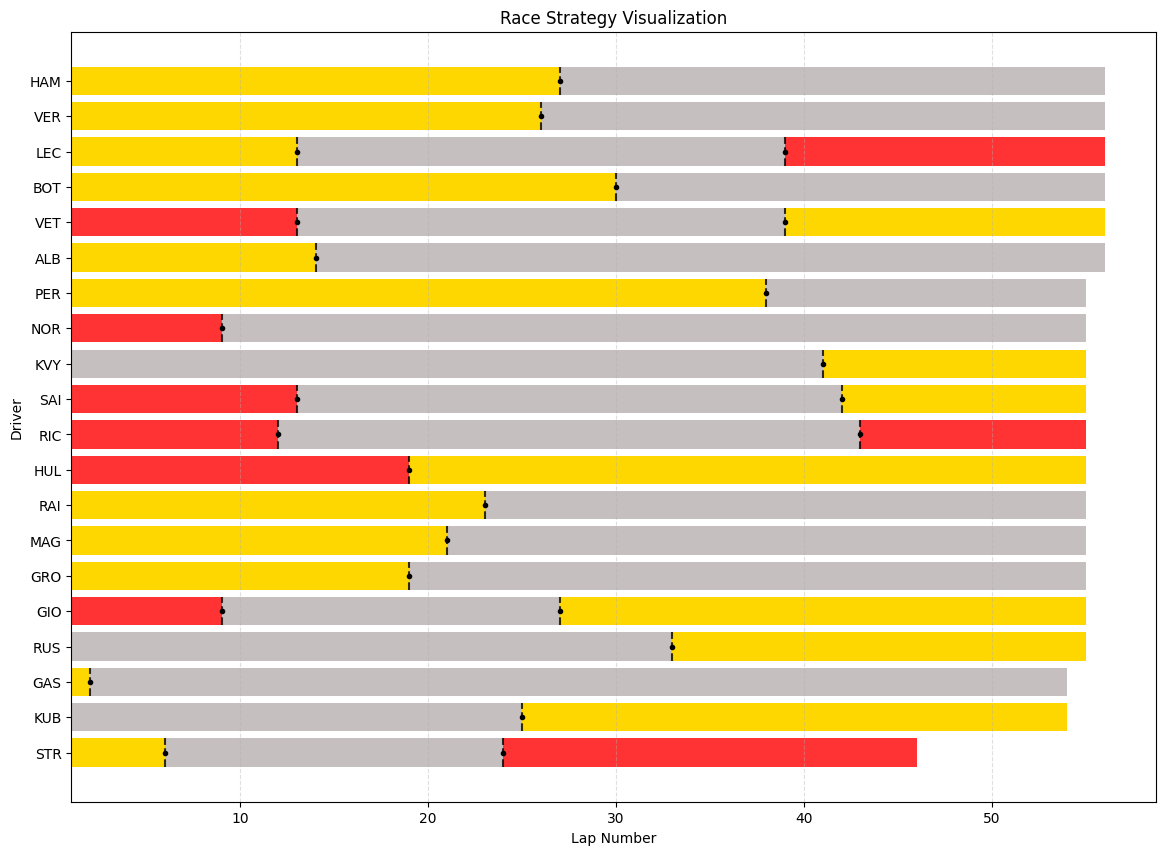

In [5]:
# Get finishing order
finishing_order = session.results.sort_values('Position')['Abbreviation'].tolist()
drivers = finishing_order[::-1]  # P1 at bottom

results = session.results
dnf_drivers = session.results[
    (session.results['Position'].isna()) |
    (session.results['Status'].str.contains('Accident|Engine|Retired|Gearbox', na=False))
]['Abbreviation'].tolist()


y_positions = {driver: i for i, driver in enumerate(drivers)}

fig, ax = plt.subplots(figsize=(14,10))

for driver in drivers:
    driver_laps = laps[laps['Driver'] == driver]
    stints = driver_laps.groupby('Stint')

    alpha = 0.35 if driver in dnf_drivers else 1.0
    y = y_positions[driver]

    for stint, data in stints:
        compound = data['Compound'].mode()[0]
        width = data['LapNumber'].max() - data['LapNumber'].min() + 1

        ax.barh(
            y,
            width,
            left=data['LapNumber'].min(),
            color=COMPOUND_COLORS.get(compound, '#AAAAAA'),
            alpha=alpha
        )

    # Pit stop markers
    pit_laps = driver_laps.loc[
        driver_laps['Stint'].diff() == 1, 'LapNumber'
    ]

    for lap in pit_laps:
        ax.plot(lap, y, marker='o', color='black', markersize=3, zorder=6)
        ax.vlines(
            lap,
            y - 0.4,
            y + 0.4,
            colors='black',
            linestyles='dashed',
            linewidth=1.5,
            alpha=0.8,
            zorder=5
        )

# Fix y-axis labels
ax.set_yticks(range(len(drivers)))
ax.set_yticklabels(drivers)

ax.set_xlabel("Lap Number")
ax.set_ylabel("Driver")
ax.set_title("Race Strategy Visualization")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()